In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from math import ceil
from tensorflow.keras.models import load_model

c:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [6]:
Train_data_dir="D:/SYNC Intern/RealTime Face Mask Detection/archive (1)/Covid-FaceMaskDetection + FaceMask 12k img -integrated dataset/Train"
Test_data_dir="D:/SYNC Intern/RealTime Face Mask Detection/archive (1)/Covid-FaceMaskDetection + FaceMask 12k img -integrated dataset/Test"
Val_data_dir="D:/SYNC Intern/RealTime Face Mask Detection/archive (1)/Covid-FaceMaskDetection + FaceMask 12k img -integrated dataset/Validation"

In [7]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

#Data generator
train_data=train_datagen.flow_from_directory(directory=Train_data_dir,
                                             target_size=(128,128),
                                             class_mode='categorical',
                                             batch_size=32)
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=Val_data_dir,
                                                  target_size=(128,128),
                                                  class_mode='categorical',
                                                  batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=Test_data_dir,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   batch_size=32)

Found 10597 images belonging to 2 classes.
Found 1106 images belonging to 2 classes.
Found 1092 images belonging to 2 classes.


In [8]:
#VGG19 model
model_file = '.h5'

if os.path.exists(model_file):
    model=load_model(model_file)
else:    
    vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

    for layer in vgg19.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(2, activation = "sigmoid"))
    

80134624/80134624 [==============================] - 73s 1us/step


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
#Training
#model=load_model("MaskDetectionnnbetter.h5")
train_steps_per_epoch = ceil(len(train_data) / 32)
val_steps_per_epoch = ceil(len(val_generator) / 32)

history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=15,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch)

<ipython-input-21-577c370c29f0>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/4
11/11 [==============================] - 93s 8s/step - loss: 0.0816 - accuracy: 0.9773 - val_loss: 0.1230 - val_accuracy: 0.9531
Epoch 2/4
11/11 [==============================] - 90s 8s/step - loss: 0.0756 - accuracy: 0.9801 - val_loss: 0.1007 - val_accuracy: 0.9531
Epoch 3/4
11/11 [==============================] - 88s 8s/step - loss: 0.0696 - accuracy: 0.9858 - val_loss: 0.0991 - val_accuracy: 0.9688
Epoch 4/4
11/11 [==============================] - 87s 8s/step - loss: 0.0856 - accuracy: 0.9773 - val_loss: 0.1028 - val_accuracy: 0.9688


In [22]:
#Evaluation
model.evaluate(test_generator)


35/35 [==============================] - 226s 6s/step - loss: 0.0735 - accuracy: 0.9771


[0.07352036237716675, 0.9771062135696411]

In [23]:
model.save('MaskDetectionModel.h5')


In [24]:
def FaceMaskDetector(image_path):
    # Load the pre-trained Haar cascade XML file for face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

    # Load the input image
    image = cv2.imread(image_path)

    # Perform face detection using the Haar cascade
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    results={1:'Without Mask',0:'With Mask'}

    # Iterate over the detected faces
    for (x, y, w, h) in faces:
        # Extract the face region of interest 
        face = image[y:y+h, x:x+w]

        face=cv2.resize(face,(128,128))
        normalized=face/255.0
        reshaped=np.reshape(normalized,(1,128,128,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        
        # Determine the label based on the face mask detection result
        label=np.argmax(result,axis=1)[0]
        
        # Draw the bounding box around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the resulting image
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(results[label])
    plt.show()

1/1 [==============================] - 1s 888ms/step


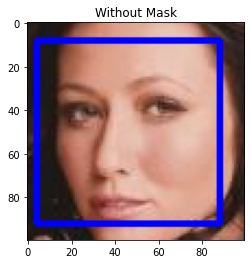

In [27]:
FaceMaskDetector("D:/SYNC Intern/RealTime Face Mask Detection/archive (1)/Covid-FaceMaskDetection + FaceMask 12k img -integrated dataset/Test/Non Mask/1014.png")

1/1 [==============================] - 0s 459ms/step


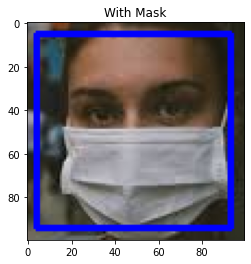

In [29]:
FaceMaskDetector("D:/SYNC Intern/RealTime Face Mask Detection/archive (1)/Covid-FaceMaskDetection + FaceMask 12k img -integrated dataset/Test/Mask/153.png")

1/1 [==============================] - 0s 476ms/step


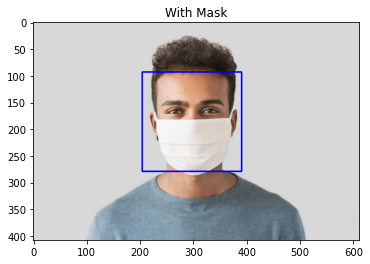

In [30]:
FaceMaskDetector("istockphoto-1272058180-612x612.jpg")

1/1 [==============================] - 0s 413ms/step


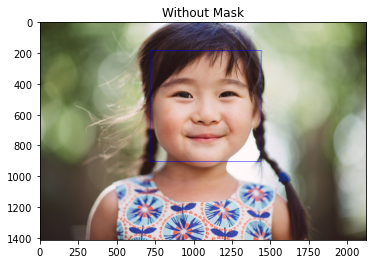

In [31]:
FaceMaskDetector("city-names-for-girls-paris-1579799881.jpg")

1/1 [==============================] - 1s 1s/step


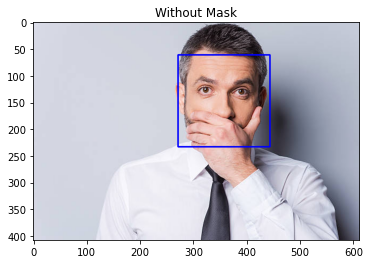

In [25]:
FaceMaskDetector("D:\SYNC Intern\istockphoto-528589231-612x612.jpg")